In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utils as u
import itertools
import pandas as pd

In [ ]:
root_img_fold = "/home/doga/PycharmProjects/objectLocalization/dataset/wounds"
image_names = ['2021-09-01_photo1.jpg','2021-09-01_photo2_rl.jpg','2021-09-01_photo3_rr.jpg']
a_image_full_path = os.path.join(root_img_fold, image_names[0])
print(a_image_full_path)
img = mpimg.imread(a_image_full_path)
print("w({:}), h({:})".format(img.shape[0],img.shape[1]))

In [ ]:
hr = 6
wc = 6
rot_c=[int(hr/2),int(wc/2)]
rot_deg=45
a = np.arange(1,1+hr*wc).reshape((hr,wc))
b = np.arange(1,1+3*hr*wc).reshape((3,hr,wc))
print(a)
print(np.swapaxes(a,0,1))

In [ ]:
rot_pixels, pix_vals_original, center_add = u.get_rotated_pixel_vals(wc, hr, rot_c=rot_c, rot_deg=rot_deg)
xyz = center_add+rot_pixels
print(pd.DataFrame(xyz, columns=['x','y','z']))

###  assign_method == 'pick', nan_action == 'clip'

In [ ]:
x = xyz[:,0].copy()
y = xyz[:,1].copy()
x1 = np.clip(np.round(x,0), 0, wc-1).astype('int')
y1 = np.clip(np.round(y,0), 0, hr-1).astype('int')
imTargetIdx = np.asarray(np.ravel_multi_index([x1, y1], (wc,hr)))
imSourceIdx = np.arange(0, len(imTargetIdx), dtype=int)
print(np.vstack((x,x1,y,y1,imSourceIdx,imTargetIdx)).T)

###  assign_method == 'pick', nan_action in ['remove', 'available']:

In [ ]:
x = xyz[:,0].copy()
y = xyz[:,1].copy()
iSoTa = [[s, int(np.ravel_multi_index([[int(i)],[int(j)]], (wc,hr)))] for s, (i, j) in enumerate(zip(x, y)) if (i<wc and i>=0 and j<hr and j>=0)]
iSoTa = np.asarray(iSoTa)
print(f"removed {len(x)-len(iSoTa)} pixels")
print(np.vstack((iSoTa[:,0],iSoTa[:,1])).T)

###  assign_method == 'interpolate', nan_action == 'clip'
if clipping will happen then no removal will happen

In [ ]:
x = xyz[:,0].copy()
y = xyz[:,1].copy()
xf, yf = np.floor(x).astype(int), np.floor(y).astype(int)
xc, yc = np.ceil(x).astype(int), np.ceil(y).astype(int)
xw, yw = x - xf, y - yf
Ax = np.clip(xf, 0, wc-1).astype('int')
Ay = np.clip(yf, 0, hr-1).astype('int')
A = np.ravel_multi_index([np.clip(xf, 0, wc-1).astype('int'),
                          np.clip(yf, 0, hr-1).astype('int')], (wc,hr)).astype(int)
B = np.ravel_multi_index([np.clip(xc, 0, wc-1).astype('int'),
                          np.clip(yf, 0, hr-1).astype('int')], (wc,hr)).astype(int)
C = np.ravel_multi_index([np.clip(xf, 0, wc-1).astype('int'),
                          np.clip(yc, 0, hr-1).astype('int')], (wc,hr)).astype(int)
D = np.ravel_multi_index([np.clip(xc, 0, wc-1).astype('int'),
                          np.clip(yc, 0, hr-1).astype('int')], (wc,hr)).astype(int)
#print(np.vstack((A,B,C,D)).T)
#print(a.ravel()[A])
#print(a[Ax,Ay])
a_final = np.zeros_like(a.ravel())
for i in range(4):
    xinds = np.clip(xf+i%2, 0, wc-1).astype('int')
    yinds = np.clip(yf+int(i/2), 0, hr-1).astype('int')
    kx1,kx2,ky1,ky2 = 1.0-i%2, (i%2-.5)*2, 1-int(i/2), (int(i/2)-.5)*2
    _wx =  kx1+kx2*xw
    _wy =  ky1+ky2*yw
    a_picked = a[xinds,yinds]
    #print(f'i{i}')
    #print(i%2,int(i/2),kx1,kx2, ky1,ky2 )
    #print(xinds.shape,yinds.shape,_wx.shape,_wy.shape,a_picked.shape)
    #print(a_picked)
    #print(a_picked*_wx*_wy)
    #print(fff2[i])
    a_final = a_final + a_picked*_wx*_wy
print(a_final.reshape(a.shape))
fff= [a[np.clip(xf+i%2, 0, wc-1).astype('int'),np.clip(yf+int(i/2), 0, hr-1).astype('int')]*((1.0-i%2)+((i%2-.5)*2)*xw)*((1-int(i/2))+((int(i/2)-.5)*2)*yw) for i in range(4)]
print(sum(fff).reshape(a.shape))

###  assign_method == 'interpolate', nan_action == 'remove'

In [ ]:
x = xyz[:,0].copy()
y = xyz[:,1].copy()
xf, yf = np.floor(x).astype(int), np.floor(y).astype(int)
xw, yw = x - xf, y - yf
Ax,Ay = xf,yf
Bx,By = xc,yf
Cx,Cy = xf,yc
Dx,Dy = xc,yc
xinds = np.vstack((Ax,Bx,Cx,Dx)).T
xslct = ((xinds>=0).astype(int)*(xinds<wc).astype(int)).all(axis=1)
yinds = np.vstack((Ay,By,Cy,Dy)).T
yslct = ((yinds>=0).astype(int)*(yinds<hr).astype(int)).all(axis=1)
slct = ((xinds>=0).astype(int)*(xinds<wc).astype(int)*(yinds>=0).astype(int)*(yinds<hr).astype(int)).all(axis=1)
slct = ((xf >= 0).astype(int) * (xf<wc-1).astype(int) * (yf >= 0).astype(int) * (yf<hr-1).astype(int)).astype(bool)
print(np.where(slct))
a_final = np.zeros_like(a.ravel(), dtype=float)
ddd= [a[(xf+i%2)[slct],(yf+int(i/2))[slct]]*((1.0-i%2)+((i%2-.5)*2)*xw[slct])*((1-int(i/2))+((int(i/2)-.5)*2)*yw[slct])  for i in range(4)]
for i in range(4):
    xinds = xf+i%2
    yinds = yf+int(i/2)
    kx1,kx2,ky1,ky2 = 1.0-i%2, (i%2-.5)*2, 1-int(i/2), (int(i/2)-.5)*2
    _wx =  kx1+kx2*xw[slct]
    _wy =  ky1+ky2*yw[slct]
    a_picked = a[xinds[slct],yinds[slct]]
    print(f'i{i}')
    #print(i%2,int(i/2),kx1,kx2, ky1,ky2 )
    #print(xinds.shape,yinds.shape,_wx.shape,_wy.shape,a_picked.shape)
    print(ddd[i])
    print(a_picked*_wx*_wy)
    print(sum(ddd[i]-a_picked*_wx*_wy))
    a_final[slct] = a_final[slct]+a_picked*_wx*_wy
print(a_final.reshape(a.shape))
a_final3 = np.zeros_like(a.ravel())
a_final3[slct] = sum(ddd)
print(a_final3.reshape(a.shape))

not rotated image with shape (7, 7)
[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19. 20. 21.]
 [22. 23. 24. 25. 26. 27. 28.]
 [29. 30. 31. 32. 33. 34. 35.]
 [36. 37. 38. 39. 40. 41. 42.]
 [43. 44. 45. 46. 47. 48. 49.]]


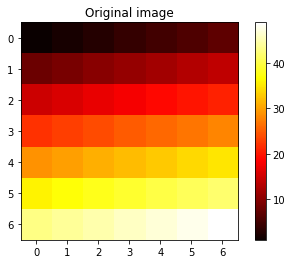

1: title=assign_method=pick, nan_action(clip), deg=90.00
deg(90) = rad(1.5707963267948966)


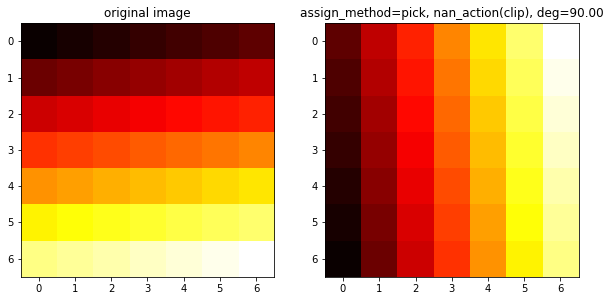

     0     1     2     3     4     5     6
0  7.0  14.0  21.0  28.0  35.0  42.0  49.0
1  6.0  13.0  20.0  27.0  34.0  41.0  48.0
2  5.0  12.0  19.0  26.0  33.0  40.0  47.0
3  4.0  11.0  18.0  25.0  32.0  39.0  46.0
4  3.0  10.0  17.0  24.0  31.0  38.0  45.0
5  2.0   9.0  16.0  23.0  30.0  37.0  44.0
6  1.0   8.0  15.0  22.0  29.0  36.0  43.0
1: no problem here
2: title=assign_method=pick, nan_action(remove), deg=90.00
deg(90) = rad(1.5707963267948966)


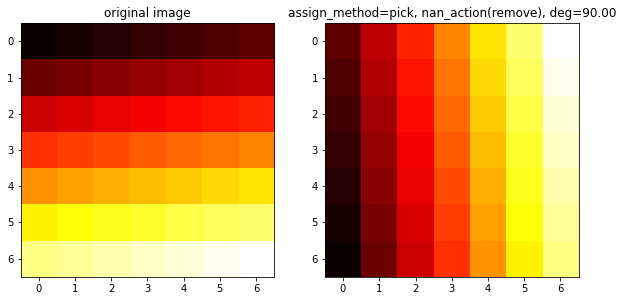

     0     1     2     3     4     5     6
0  7.0  14.0  21.0  28.0  35.0  42.0  49.0
1  6.0  13.0  20.0  27.0  34.0  41.0  48.0
2  5.0  12.0  19.0  26.0  33.0  40.0  47.0
3  4.0  11.0  18.0  25.0  32.0  39.0  46.0
4  3.0  10.0  17.0  24.0  31.0  38.0  45.0
5  2.0   9.0  16.0  23.0  30.0  37.0  44.0
6  1.0   8.0  15.0  22.0  29.0  36.0  43.0
2: no problem here


In [127]:
hr = 7
wc = 7
rot_c=[int(hr/2),int(wc/2)]
#print(rot_c)
chs = 1 
rot_deg=90
a = np.arange(1,1+hr*wc*chs).reshape((hr,wc))#/(hr*wc*1)
t_img = u.img_rotator()
t_img.fit(image=a)
print(f"not rotated image with shape {a.shape}")
print(t_img.image)
plt.imshow(t_img.image, cmap = plt.cm.hot)
plt.title("Original image")
plt.colorbar()
plt.show()
pd.set_option("display.precision", 2)
i=1
for asme in ['pick','interpolate']:
    for nanact in ['clip','remove']:
        if asme=='interpolate':
            continue
        titStr = f"assign_method={asme}, nan_action({nanact}), deg={rot_deg:4.2f}"
        print(f"{i}: title={titStr}")
        t_img = u.img_rotator()
        t_img.fit(image=a, assign_method=asme, nan_action=nanact, rot_c=rot_c, rot_deg=rot_deg)
        sDh = t_img.apply_rotation()
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(t_img.image, cmap=plt.cm.hot)
        axes[0].set_title("original image")
        axes[1].imshow(t_img.imRot, cmap=plt.cm.hot)
        axes[1].set_title(titStr)
        plt.show()
        print(pd.DataFrame(t_img.imRot))
        print(f"{i}: no problem here")
        i+=1

not rotated image with shape (3, 3)
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


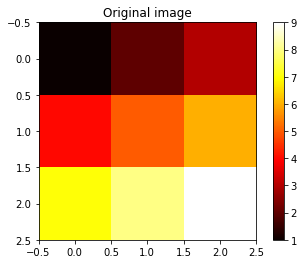

1: title=assign_method=pick, nan_action(clip), deg=90.00
deg(90) = rad(1.5707963267948966)


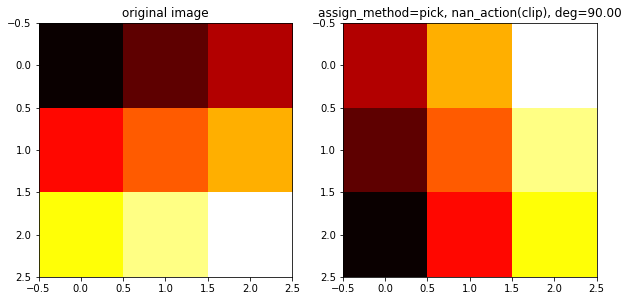

     0    1    2
0  3.0  6.0  9.0
1  2.0  5.0  8.0
2  1.0  4.0  7.0
1: no problem here
2: title=assign_method=pick, nan_action(remove), deg=90.00
deg(90) = rad(1.5707963267948966)


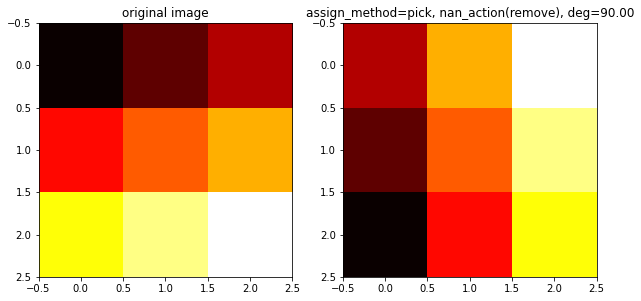

     0    1    2
0  3.0  6.0  9.0
1  2.0  5.0  8.0
2  1.0  4.0  7.0
2: no problem here


In [128]:
hr = 3
wc = 3
rot_c=[int(hr/2),int(wc/2)]
#print(rot_c)
chs = 1 
rot_deg=90
a = np.arange(1,1+hr*wc*chs).reshape((hr,wc))#/(hr*wc*1)
t_img = u.img_rotator()
t_img.fit(image=a)
print(f"not rotated image with shape {a.shape}")
print(t_img.image)
plt.imshow(t_img.image, cmap = plt.cm.hot)
plt.title("Original image")
plt.colorbar()
plt.show()
pd.set_option("display.precision", 2)
i=1
for asme in ['pick','interpolate']:
    for nanact in ['clip','remove']:
        if asme=='interpolate':
            continue
        titStr = f"assign_method={asme}, nan_action({nanact}), deg={rot_deg:4.2f}"
        print(f"{i}: title={titStr}")
        t_img = u.img_rotator()
        t_img.fit(image=a, assign_method=asme, nan_action=nanact, rot_c=rot_c, rot_deg=rot_deg)
        sDh = t_img.apply_rotation()
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(t_img.image, cmap=plt.cm.hot)
        axes[0].set_title("original image")
        axes[1].imshow(t_img.imRot, cmap=plt.cm.hot)
        axes[1].set_title(titStr)
        plt.show()
        print(pd.DataFrame(t_img.imRot))
        print(f"{i}: no problem here")
        i+=1

In [ ]:
sDh["x"][((sDh["x"]<=0.001).astype(int) * (sDh["x"]>=0.0).astype(int)).astype(bool)] 

In [ ]:
for x, xf, xw, y, yf, yw in zip(sDh["x"], sDh["xf"], sDh["xw"], sDh["y"], sDh["yf"], sDh["yw"]):
    slct = ((xf >= 0).astype(int) * (xf<6).astype(int) * (yf >= 0).astype(int) * (
                        yf < 6).astype(int)).astype(bool)
    print(f"x({x}), xf({xf}), xw({xw}), y({y}), yf({yf}), yw({yw})")

In [ ]:
print(np.asarray([0.4,0.5,0.6]).astype(int))
print(np.round(np.asarray([0.4,0.5,0.6]), 0))
print(np.round(np.asarray([0.4,0.5,0.6]), 0).astype(int))

In [ ]:
imTargetIdx = np.asarray([0,1,5,6]) #is linearly increasing with all values between 0-8
imSourceIdx = np.asarray([2,3,6,7])
print(h)
#lets suppose 1 layer of image has 9 pixels - 3x3
add_h = np.arange(0,3)*9
print(add_h)
print(np.expand_dims(add_h, axis=0).T + imTargetIdx)
print(np.expand_dims(add_h, axis=0).T + imSourceIdx)

In [ ]:
h

In [ ]:
a

In [ ]:
a.shape

In [ ]:
a.ravel()

In [ ]:
a.transpose((2,1,0))

In [ ]:
a.transpose((2,1,0)).ravel()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/doga/PycharmProjects/objectLocalization/rarrow.jpg
not rotated image with shape (289, 385, 3)


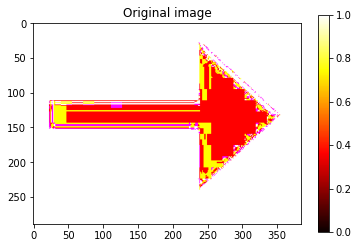

1: title=assign_method=interpolate, nan_action(clip), deg=45.00
deg(45) = rad(0.7853981633974483)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


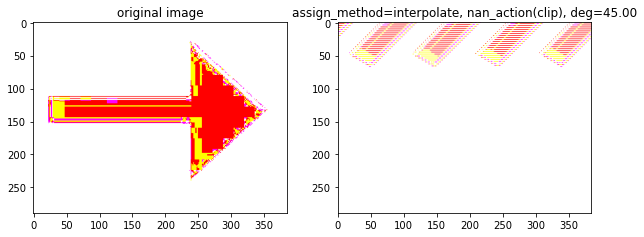

1: no problem here
2: title=assign_method=interpolate, nan_action(remove), deg=45.00
deg(45) = rad(0.7853981633974483)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


select=
[False  True  True ... False False False]
imRot1:
(12, 34883)
[array([5.28122292e+01, 1.65840166e-14, 6.56266248e+01, ...,
       8.38594022e+01, 4.64373918e+01, 1.12109781e+02]), array([ 21.87554159, 149.37554159, 158.43668761, ..., 171.14059784,
        28.25037898,  68.20244807]), array([1.27500000e+02, 1.17266706e-14, 9.06114601e+00, ...,
       2.38342756e-12, 1.12109781e+02, 4.64373918e+01]), array([5.28122292e+01, 1.05624458e+02, 2.18755416e+01, ...,
       4.86410834e-12, 6.82024481e+01, 2.82503790e+01]), array([5.28122292e+01, 1.65840166e-14, 6.56266248e+01, ...,
       8.38594022e+01, 4.64373918e+01, 1.12109781e+02]), array([ 21.87554159, 149.37554159, 158.43668761, ..., 171.14059784,
        28.25037898,  68.20244807]), array([1.27500000e+02, 1.17266706e-14, 9.06114601e+00, ...,
       2.38342756e-12, 1.12109781e+02, 4.64373918e+01]), array([5.28122292e+01, 1.05624458e+02, 2.18755416e+01, ...,
       4.86410834e-12, 6.82024481e+01, 2.82503790e+01]), array([5.28122292

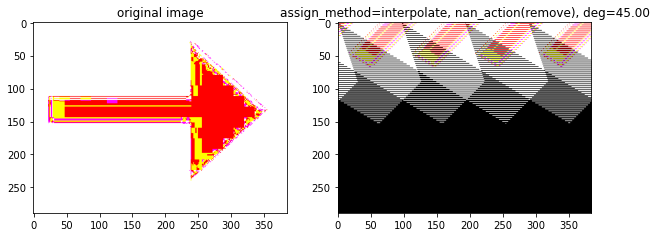

2: no problem here


In [126]:
rot_deg=45
root_img_fold = "/home/doga/PycharmProjects/objectLocalization/"
a_image_full_path = os.path.join(root_img_fold, "rarrow.jpg")
print(a_image_full_path)
a = mpimg.imread(a_image_full_path)
t_img = u.img_rotator()
t_img.fit(image=a)
print(f"not rotated image with shape {a.shape}")
#print(t_img.image)
plt.imshow(t_img.image, cmap = plt.cm.hot)
plt.title("Original image")
plt.colorbar()
plt.show()
pd.set_option("display.precision", 2)
i=1
for asme in ['interpolate']:
    for nanact in ['clip','remove']:
        titStr = f"assign_method={asme}, nan_action({nanact}), deg={rot_deg:4.2f}"
        print(f"{i}: title={titStr}")
        t_img = u.img_rotator()
        t_img.fit(image=a, assign_method=asme, nan_action=nanact, rot_c=rot_c, rot_deg=rot_deg)
        sDh = t_img.apply_rotation()
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(t_img.image, cmap=plt.cm.hot)
        axes[0].set_title("original image")
        axes[1].imshow(t_img.imRot, cmap=plt.cm.hot)
        axes[1].set_title(titStr)
        plt.show()
        #print(pd.DataFrame(t_img.imRot))
        print(f"{i}: no problem here")
        i+=1

In [99]:
hr = 2
wc = 2
rot_c=[int(hr/2),int(wc/2)]
#print(rot_c)
rot_deg=45
a = np.arange(1,1+hr*wc*3).reshape((hr,wc,3))
b = 3*np.arange(1,1+hr*wc*3).reshape((hr,wc,3))
print(a)
print(a.ravel())
print(a.transpose(2,1,0))
print(a.transpose(2,1,0).ravel())
print(b.ravel())

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[[[ 1  7]
  [ 4 10]]

 [[ 2  8]
  [ 5 11]]

 [[ 3  9]
  [ 6 12]]]
[ 1  7  4 10  2  8  5 11  3  9  6 12]
[ 3  6  9 12 15 18 21 24 27 30 33 36]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not rotated image with shape (3, 3, 3)
[[[255.   0.   0.]
  [255. 255.   0.]
  [  0. 255.   0.]]

 [[255.   0. 255.]
  [  0.   0.   0.]
  [  0. 255. 255.]]

 [[  0.   0. 255.]
  [100. 100. 100.]
  [255. 255. 255.]]]


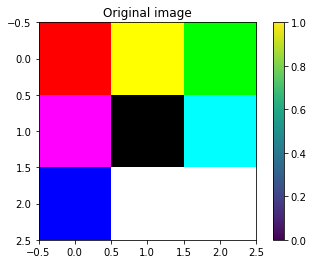

In [106]:
b = np.asarray([255,  0,  0,
                255,255,  0,
                  0,255,  0,
                255,  0,255,
                  0,  0,  0,
                  0,255,255,
                  0,  0,255,
                100,100,100,
                255,255,255]).reshape(3,3,3)
t_img = u.img_rotator()
t_img.fit(image=b)
print(f"not rotated image with shape {a.shape}")
print(t_img.image)
plt.imshow(t_img.image)
plt.title("Original image")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: title=assign_method=pick, nan_action(clip), deg=45.00
deg(45) = rad(0.7853981633974483)

*******
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]*****

map2d_c = (9, 3)
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]]
map2d_c = (9, 3)


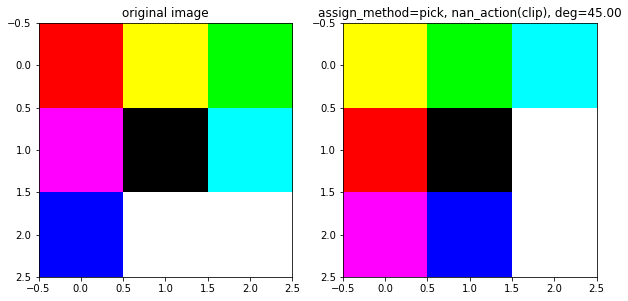

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: no problem here
2: title=assign_method=pick, nan_action(remove), deg=45.00
deg(45) = rad(0.7853981633974483)

*******
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]*****

map2d_c = (9, 3)
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]]
map2d_c = (9, 3)


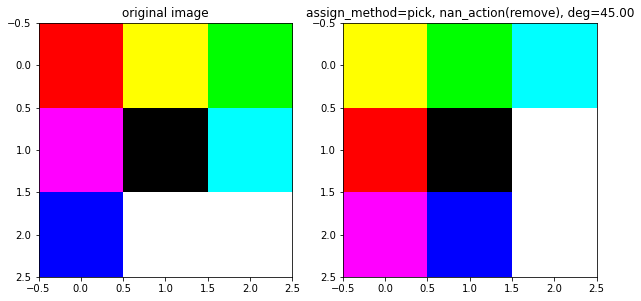

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2: no problem here
3: title=assign_method=interpolate, nan_action(clip), deg=45.00
deg(45) = rad(0.7853981633974483)


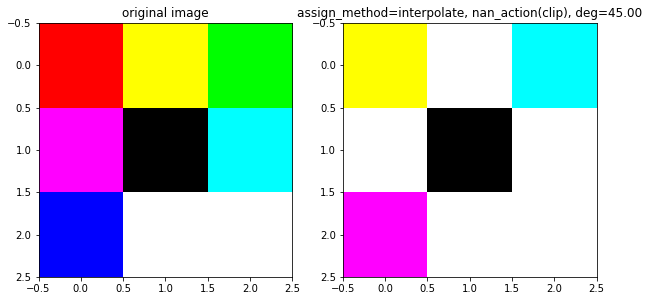

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3: no problem here
4: title=assign_method=interpolate, nan_action(remove), deg=45.00
deg(45) = rad(0.7853981633974483)
select=
[False  True False  True  True  True False  True False]
imRot1:
(12, 5)
[array([ 52.8122292, 127.5      ,   0.       ,   0.       ,  52.8122292]), array([ 0.        , 52.8122292 ,  0.        , 20.71067812,  0.        ]), array([ 0.       , 52.8122292,  0.       ,  0.       ,  0.       ]), array([  0.        ,   0.        ,   0.        , 127.5       ,
        20.71067812]), array([52.8122292,  0.       ,  0.       ,  0.       ,  0.       ]), array([ 0.        ,  0.        ,  0.        , 20.71067812,  0.        ]), array([127.5      ,  52.8122292,   0.       ,  52.8122292,   0.       ]), array([ 52.8122292 ,   0.        ,   0.        , 127.5       ,
        20.71067812]), array([ 0.       ,  0.       ,  0.       ,  0.       , 52.8122292]), array([  0.        ,  52.8122292 ,   0.        ,  20.71067812,
       127.5       ]), array([ 0.       ,  0.       ,  0.     

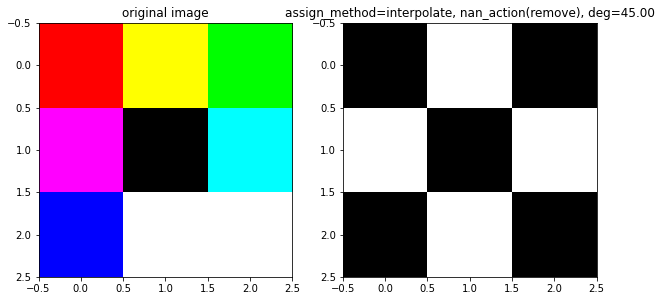

4: no problem here


In [125]:
i=1
for asme in ['pick','interpolate']:
    for nanact in ['clip','remove']:
        titStr = f"assign_method={asme}, nan_action({nanact}), deg={rot_deg:4.2f}"
        print(f"{i}: title={titStr}")
        t_img = u.img_rotator()
        t_img.fit(image=b, assign_method=asme, nan_action=nanact, rot_c=rot_c, rot_deg=rot_deg)
        sDh = t_img.apply_rotation()
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(t_img.image, cmap=plt.cm.hot)
        axes[0].set_title("original image")
        axes[1].imshow(t_img.imRot, cmap=plt.cm.hot)
        axes[1].set_title(titStr)
        plt.show()
        #print(pd.DataFrame(t_img.imRot))
        print(f"{i}: no problem here")
        i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: title=assign_method=pick, nan_action(clip), deg=45.00
deg(45) = rad(0.7853981633974483)


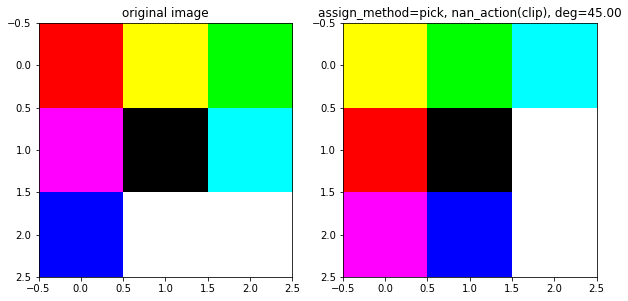

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: no problem here
2: title=assign_method=pick, nan_action(remove), deg=45.00
deg(45) = rad(0.7853981633974483)


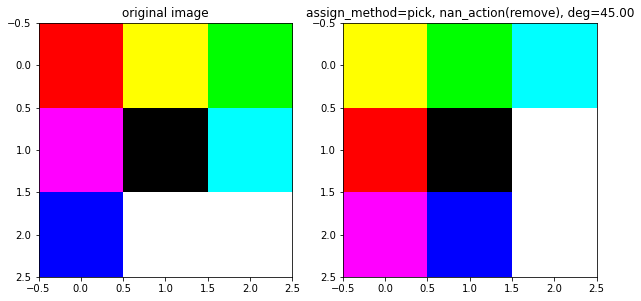

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2: no problem here
3: title=assign_method=interpolate, nan_action(clip), deg=45.00
deg(45) = rad(0.7853981633974483)


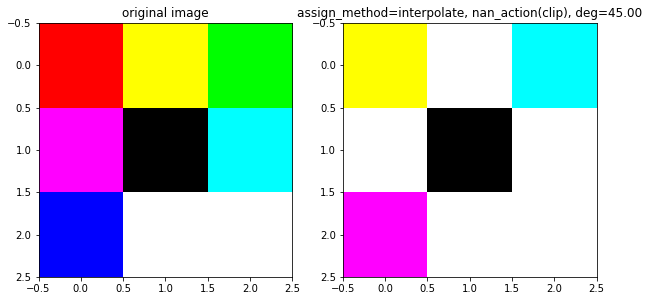

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3: no problem here
4: title=assign_method=interpolate, nan_action(remove), deg=45.00
deg(45) = rad(0.7853981633974483)
select=
[False  True False  True  True  True False  True False]
imRot1:
(12, 5)
[array([ 52.8122292, 127.5      ,   0.       ,   0.       ,  52.8122292]), array([ 0.        , 52.8122292 ,  0.        , 20.71067812,  0.        ]), array([ 0.       , 52.8122292,  0.       ,  0.       ,  0.       ]), array([  0.        ,   0.        ,   0.        , 127.5       ,
        20.71067812]), array([52.8122292,  0.       ,  0.       ,  0.       ,  0.       ]), array([ 0.        ,  0.        ,  0.        , 20.71067812,  0.        ]), array([127.5      ,  52.8122292,   0.       ,  52.8122292,   0.       ]), array([ 52.8122292 ,   0.        ,   0.        , 127.5       ,
        20.71067812]), array([ 0.       ,  0.       ,  0.       ,  0.       , 52.8122292]), array([  0.        ,  52.8122292 ,   0.        ,  20.71067812,
       127.5       ]), array([ 0.       ,  0.       ,  0.     

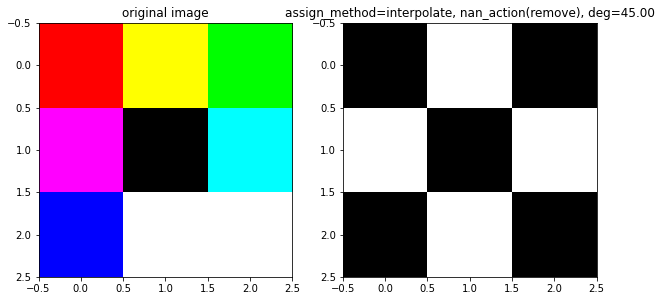

4: no problem here


In [103]:
i=1
for asme in ['pick','interpolate']:
    for nanact in ['clip','remove']:
        titStr = f"assign_method={asme}, nan_action({nanact}), deg={rot_deg:4.2f}"
        print(f"{i}: title={titStr}")
        t_img = u.img_rotator()
        t_img.fit(image=b, assign_method=asme, nan_action=nanact, rot_c=rot_c, rot_deg=rot_deg)
        sDh = t_img.apply_rotation()
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(t_img.image, cmap=plt.cm.hot)
        axes[0].set_title("original image")
        axes[1].imshow(t_img.imRot, cmap=plt.cm.hot)
        axes[1].set_title(titStr)
        plt.show()
        #print(pd.DataFrame(t_img.imRot))
        print(f"{i}: no problem here")
        i+=1